# Introduction to Vandermonde Interpolation

- this tutorial is also available as [colab notebook](https://colab.research.google.com/drive/1xTYeoDljNTh0wTzF1-5qGP1rRqelzbdy?usp=sharing)

Before diving into images let's talk about interpolation which is at the heart of our image processing method...

## Interpolation

 Interpolation is the act of fitting a function on some measured data points $(x_1, y_1)$, $(x_2, y_2)$, ... for the purpose of infering other points.

This is useful say if you want to characterize some data but don't have the time or resources to sample every possible point. With interpolation you can measure a few points then infer the rest using your fit function.

Let's demonstrate with an example below where we use a polynomial of degree $n$ ($p(x)=\sum_{i=0}^{n}c_ix^i$) to fit data from some arbitrary function (in practice we don't know the function and the data is noisy). 

In [ ]:
import numpy as np 
import random
import matplotlib.pyplot as plt
%matplotlib inline

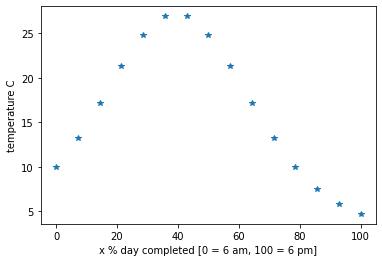

In [2]:
numSamples=15 #number of sampled data points
sig=0.01
timeInPercent=np.linspace(0,100,numSamples)+np.random.normal(size=numSamples)*sig
b = 10*np.exp(np.sin(0.04*timeInPercent))+np.random.normal(size=numSamples)*sig
plt.plot(timeInPercent,b,'*')
plt.xlabel('x % day completed [0 = 6 am, 100 = 6 pm]')
plt.ylabel('temperature C')
plt.show()

## An applied example

The goal of Vandermonde interpolation is to transform some arbitrary input into output that lies upon the same function curve as measured by your experimental data. This agrees with our original problem statement of only having results from a few select input values.

Using the above situation as an example, we took 15 measurements of temperature over a day (every 48 minutes). Then the next day someone comes to us and asks what the temperature was at exactly 3:15pm yesterday [77.08 % of the day], however we don't have a measurement for that exact time. What we want is a function that we can input an arbitrary time during the day (e.g 77.08%) and get a good estimate of the temperature at that time. We use Vandermonde interpolation to find this time to temperature transformation (function).

Polynomials are a common choice of interpolation function because they are linear, differentiable, and straightforward to understand. We can write our polynomial to predict temperature $T$ for any given time of day $x$ as $\hat{T}=\sum_{n=0}^{N-1}c_n x^n$ where we must first find the set of $N$ coefficients for our $N-1$ degree polynomial. 

Due to the linear nature of polynomials this polynomial function can be described as a linear transformation of vector $x$ by matrix $A$,

$$
\hat{T}=Ac=
\begin{bmatrix}
1 & x_0 & x_0^2  & \dots  & x_0^n \\ 
1 & x_1 & x_1^2  & \dots  & x_1^n \\
\vdots  &\vdots  & \vdots & \ddots &\vdots \\
1 & x_m & x_m^2  & \dots  & x_m^n         \\
\end{bmatrix}
\begin{bmatrix}
c_0 \\
c_1 \\
\vdots \\
c_{n}
\end{bmatrix}
$$

where $A$ is the *transposed* Vandermonde matrix with each element described by $A_{ij} = x_i^j$. This matrix has a size of $M$ rows for each time measurement ($M=15$ in our example) by $N+1$ columns for the monomial terms of the degree $N$ polynomial that we want to approximate our function as.

Thus by solving this linear system we can find the $N+1$ $c$ coefficients to best estimate temperature $T$ given time $x$ using the transformation $A$.




As a concrete example of the Vandermonde matrix we can call Numpy's vandermonde function for 3 monomials and sampling 10 even sampled points 1 through 15

In [3]:
n=3
x = np.arange(1,16)
vanderMat = np.vander(x,3, increasing=True)
print(vanderMat)

[[  1   1   1]
 [  1   2   4]
 [  1   3   9]
 [  1   4  16]
 [  1   5  25]
 [  1   6  36]
 [  1   7  49]
 [  1   8  64]
 [  1   9  81]
 [  1  10 100]
 [  1  11 121]
 [  1  12 144]
 [  1  13 169]
 [  1  14 196]
 [  1  15 225]]


## Vandermonde interpolation

A polynomial fit can be described in matrix terms using the Vandermonde matrix. Say wish to characterize some unknown function $f(x)$, (e.g. the -log attenuation of x-rays $y$ as a function of penetration depth $x$ for the purpose of eventually correcting it). We measure $y$ at $n$ different distances $x$. This can be approximated by the following polynomial

$p(x) = \bf{A}c = \begin{bmatrix}
1 & x_0 & x_0^2  & \dots  & x_0^n \\ 
1 & x_1 & x_1^2  & \dots  & x_1^n \\
\vdots  &\vdots  & \vdots & \ddots &\vdots \\
1 & x_m & x_m^2  & \dots  & x_m^n         \\
\end{bmatrix} \begin{bmatrix}
c_0\\ 
c_1\\
\vdots\\
c_n\\
\end{bmatrix} =\begin{bmatrix}
y_0\\ 
y_1\\
\vdots\\
y_n\\
\end{bmatrix} \approx f(x)$

for right set of coefficients $c$, the goal of polynomial fitting is to solve for those $n$ coefficients

In [ ]:
n=3 #the polynomial degree 
A=np.vander(timeInPercent,n)
x=np.linalg.lstsq(A,b,rcond=None)[0]

In [ ]:
def compareEstimatewithExpected(independentVar, estimate, expected):
  fig1 = plt.figure()
  plt.scatter(independentVar,expected)
  line1, = plt.plot(independentVar,y,c='orange')
  title1=plt.title("1D Vandermonde polynomial fitting")
  plt.legend(["data","fit"])
  plt.show()
  return fig1, line1, title1

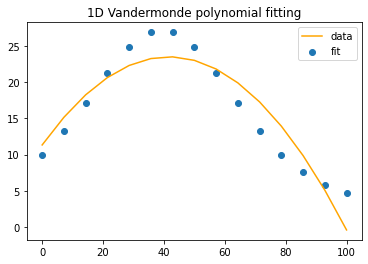

In [6]:
y=A@x
fig1, line1, title1 = compareEstimatewithExpected(timeInPercent, y, b)

Hmmm... That's close, but you can only get so far with $n=3$ monomials aka a quadratic fit, $p(x)=c_0x^2+c_1x+c_2$.

What if we add more monomial terms? 

In [8]:
from matplotlib import animation, rc
import time
rc('animation', html='jshtml')

def animate1(i):
  A=np.vander(timeInPercent,i)
  x=np.linalg.lstsq(A,b,rcond=None)[0]
  line1.set_ydata(A@x)
  title1.set_text("Degree " + str(i) + " polynomial fit")
  return line1,

animation.FuncAnimation(fig1, animate1, np.arange(0, 10), interval=500)

## An abbreviated version
I should mention that numpy includes a convencience function for A = np.vander(time, deg, increasing=True) followed by yhat = Ax, called polyval where yhat = np.polynomial.polynomial.polyval(time, x)

https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.polynomial.polynomial.polyval.html#numpy.polynomial.polynomial.polyval

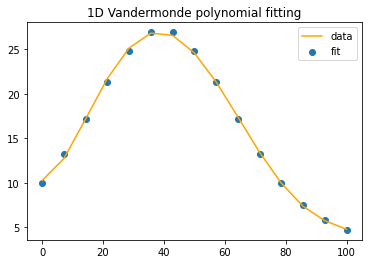

(<Figure size 432x288 with 1 Axes>,
 Text(0.5, 1.0, '1D Vandermonde polynomial fitting'))

In [ ]:
n=6 #the polynomial degree 
A=np.vander(timeInPercent,n, increasing=True)
x=np.linalg.lstsq(A,b,rcond=None)[0]
y = np.polynomial.polynomial.polyval(timeInPercent, x)

compareEstimatewithExpected(timeInPercent, y, b)

## Vondermonde interpolation for linearization #

Vandermonde interpolation can be used for more than approximating an unknown function by a polynomial, it can also be used to linearize nonlinear data. This is useful in CT reconstruction which assumes a linear relationship between -log(Transmission) data and path length. The reason that this is not the case in practice is primarily because x-rays from standard tube sources are polychromatic with lower energy rays being attenuated at a greater rate than higher energy ones.

To correct for this we can use vandermonde interpolation to remap our measured polychromatic attenuation values (-log(Transmission)) to what we would expect had they come from monochromatic x-rays with the desired linear relationship.

We can demonstrate this below with a 1D example:

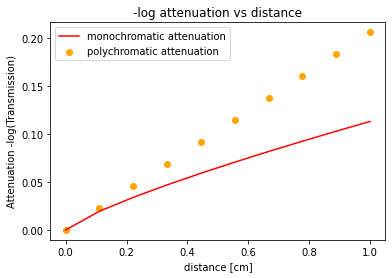

In [ ]:
n_samples = 10 #number of distances along x to measure attenuation through our homogenous sample of material mu
d = np.linspace(0,1,n_samples) #vector of sampled distances
mu = 0.2059 #attenuation coefficient of water at 60keV for this example units [cm^-2]
lin_atten = mu*d #the desired linear attenuation of 60 keV x-rays as a function of distance d
fig = plt.figure()
plt.scatter(d,lin_atten,c='orange')
#as a result of beam hardening, the relationship is no longer linear (arbitrary choice of coefficient and exponent)
measured_atten = 0.4*lin_atten**0.8
#measured_atten = np.sin(lin_atten**0.8) #uncomment to experiment with even more nonlinear functions
line, = plt.plot(d,measured_atten,'r')
plt.xlabel("distance [cm]")
plt.ylabel("Attenuation -log(Transmission)")
title=plt.title("-log attenuation vs distance")
plt.legend(("monochromatic attenuation","polychromatic attenuation"))
plt.show()

We can use the same tools developed in Vandermonde polynomial interpolation to linearize our measured polychromatic attenuation values to match what we would expect from a monochromatic beam

In [ ]:
from matplotlib import animation, rc
import time
rc('animation', html='jshtml')

def animate(i):
  if i == 0:
    line.set_ydata(measured_atten)
    title.set_text("original")
  else:
    A = np.vander(measured_atten,i)
    x=np.linalg.lstsq(A,lin_atten,rcond=None)[0]
    line.set_ydata(A@x)
    title.set_text("Degree " + str(i) + " polynomial fit")
  return line,

animation.FuncAnimation(fig, animate, np.arange(0, 10), interval=500)

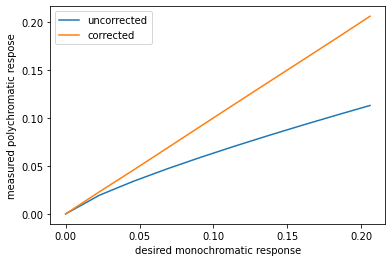

In [ ]:
deg=5
A = np.vander(measured_atten,deg)
x=np.linalg.lstsq(A,lin_atten,rcond=None)[0]
corrected_measured=A@x

plt.plot(lin_atten,measured_atten,lin_atten,corrected_measured)
plt.xlabel("desired monochromatic response")
plt.ylabel("measured polychromatic respose")
plt.legend(("uncorrected","corrected"))
plt.show()

Now go back and experiment with measured_atten giving it different nonlinear functions of d and see what order polynomial is required for the fit

Move on to the next notebook on LU decomposition:
https://colab.research.google.com/drive/1SJtGSP_1XcjLh0pyF_RwmakUMdDuNcxt
